<a href="https://colab.research.google.com/github/nunezal/berryBot/blob/main/copy_of_berrybot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax
!pip install playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

# Set up GPU rendering (your existing code - keep this)
import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )
print('Installation successful.')

# Imports from Playground example
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from datetime import datetime
import functools
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.config import manipulation_params

import os
import shutil  # Import the shutil module
import mediapy as media

# List available environments
all_envs = registry.manipulation.ALL
print(all_envs)

env_name = 'PandaPickCubeOrientation' # Starting with this base environment
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
print(env_cfg)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.6/708.6 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.2 MB/s eta 0:00:00
Setting environment variable to use GPU rendering:
env: 

Cloning mujoco_menagerie: ██████████| 100/100 [00:28<00:00]


Checking out commit 5e6af47a49bf8ae27581615b54045107b20ce584
Successfully downloaded mujoco_menagerie
['AlohaSinglePegInsertion', 'PandaPickCube', 'PandaPickCubeOrientation', 'PandaPickCubeCartesian', 'PandaOpenCabinet', 'PandaRobotiqPushCube', 'LeapCubeReorient', 'LeapCubeRotateZAxis']
action_repeat: 1
action_scale: 0.04
ctrl_dt: 0.02
episode_length: 150
reward_config:
  scales:
    box_target: 8.0
    gripper_box: 4.0
    no_floor_collision: 0.25
    robot_target_qpos: 0.3
sim_dt: 0.005



## Training Env

Meshes copied to package mesh directory: /usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda


""

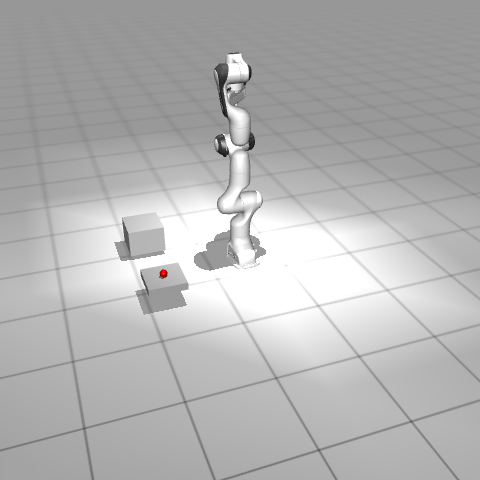

In [3]:
# --- Define target package mesh directory from the error message ---
target_package_mesh_dir = "/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda"

# --- Source mesh directory (where you have meshes in Google Drive) ---
source_mesh_dir = "/content/drive/MyDrive/robo/arm_mesh"

# --- Copy Meshes to Package Directory ---
os.makedirs(target_package_mesh_dir, exist_ok=True)  # Create target directory if it doesn't exist

for filename in os.listdir(source_mesh_dir):
    if filename.endswith((".stl", ".obj", ".msh")):  # Check for common mesh file extensions
        source_path = os.path.join(source_mesh_dir, filename)
        target_path = os.path.join(target_package_mesh_dir, filename)
        # Handle existing files (overwrite, skip, or prompt)
        if os.path.exists(target_path):
            continue  # Skip existing files
            # Or: raise FileExistsError(f"File {filename} already exists")
        shutil.copy2(source_path, target_path)  # Copy while preserving metadata
print(f"Meshes copied to package mesh directory: {target_package_mesh_dir}")

# --- Find mjx_panda.xml Path (still needed for include) ---
def find_mjx_panda_xml_path():
    """Finds the absolute path to mjx_panda.xml."""
    import mujoco_playground
    playground_path = os.path.dirname(mujoco_playground.__file__)

    mjx_panda_path = None
    possible_paths_panda = [
        "/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml",
        os.path.join(playground_path, '_src', 'manipulation', 'franka_emika_panda', 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'manipulation', 'franka_emika_panda', 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'franka_emika_panda', 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'mjx_panda.xml')
    ]

    for path in possible_paths_panda:
        if os.path.exists(path):
            mjx_panda_path = path
            break
    return mjx_panda_path

mjx_panda_path = find_mjx_panda_xml_path()
if not mjx_panda_path:
    raise FileNotFoundError("Could not find mjx_panda.xml")


mjx_panda_path = '/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml'

modified_xml_string = f"""
<mujoco model="berry_picking_playground_scratch">
    <!-- Include panda robot from mjx_panda.xml using absolute path -->
    <include file="{mjx_panda_path}"/>

    <option timestep="0.002" iterations="100" solver="Newton" gravity="0 0 -9.81"/>



    <visual>
      <headlight diffuse=".8 .8 .8" ambient=".2 .2 .2" specular="1 1 1"/>
      <global azimuth="-20" elevation="-30"/>
      <rgba force="1 0 0 1"/>
      <map force="0.01"/>
      <quality shadowsize="8192"/>
      <scale contactwidth="0.075" contactheight="0.025" forcewidth="0.05" com="0.05" framewidth="0.01" framelength="0.2"/>
    </visual>

    <size nstack="3000"/>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512"/>
        <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 .2 .3" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>
        <material name="matplane" reflectance="0.3" texture="texplane" texrepeat="1 1" texuniform="true"/>
        <material name="berry" rgba="0.8 0 0 1"/>
        <material name="plate" rgba="0.7 0.7 0.7 1"/>
        <material name="bowl" rgba="0.8 0.8 0.8 1"/>

        <!-- Materials -->
        <material name="white2" rgba="1 1 1 1"/>
        <material name="off_white2" rgba="0.901961 0.921569 0.929412 1"/>
        <material name="black2" rgba="0.25 0.25 0.25 1"/>
        <material name="green2" rgba="0 1 0 1"/>
        <material name="light_blue2" rgba="0.039216 0.541176 0.780392 1"/>

        <!-- Ground plane texture/material -->
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0"/>
    </asset>

    <worldbody>
        <!-- Add Camera here inside worldbody -->
        <camera name="closeup_berry" pos="0 0 2" quat="0.707 0.707 0 0" mode="targetbodycom" target="berry"/>

        <!-- Ground plane -->
        <geom name="floor" size="0 0 0.05" type="plane" material="groundplane" contype="1"/>

        <!-- Plate -->
        <body name="plate" pos="-0.25 0.5 0.1">
            <geom name="plate_geom" type="box" size="0.1 0.1 0.02" material="plate"/>
        </body>

        <!-- Bowl -->
        <body name="bowl" pos="0.25 0.5 0.1">
            <geom name="bowl_geom" type="box" size="0.1 0.1 0.075" material="bowl"/>
        </body>

        <!-- Berry -->
        <body name="berry" pos="-0.25 0.5 0.135">
            <joint name="berry_joint" type="free" damping="0.1"/>
            <geom name="berry_geom" type="capsule" size="0.02 0.0001" fromto="0 0 -0.0001 0 0 0.0001" material="berry"/>
        </body>

         <!-- Panda Robot (included from mjx_panda.xml) -->
    </worldbody>
</mujoco>
        """

if modified_xml_string:
    # Render the scene
    model = mujoco.MjModel.from_xml_string(modified_xml_string)
    data = mujoco.MjData(model)
    with mujoco.Renderer(model, width=480, height=480) as renderer:
        mujoco.mj_forward(model, data)
        renderer.update_scene(data)
        image = renderer.render()
        media.show_image(image)

In [4]:
from mujoco_playground._src import mjx_env
from ml_collections import config_dict
import os
import jax
import jax.numpy as jp
import mediapy as media
import numpy as np
import mujoco
from mujoco.mjx._src import math
from typing import Dict
from mujoco_playground._src.manipulation.franka_emika_panda import pick
from mujoco_playground._src import collision

self.config inside _debug_config: True


/usr/local/lib/python3.11/dist-packages/jax/_src/linear_util.py:193: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = self.f(*args, **dict(self.params, **kwargs))
/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/xla.py:155: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/xla.py:155: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


Step Reward: 1.2981045246124268, Metrics: {'berry_target': Array(1.279, dtype=float32), 'gripper_berry': Array(0.019, dtype=float32), 'gripper_berry_lift': Array(0., dtype=float32), 'robot_collision_penalty': Array(-0., dtype=float32, weak_type=True)}, Done: 0.0


100%|██████████| 1/1 [00:00<00:00, 88.03it/s]


""

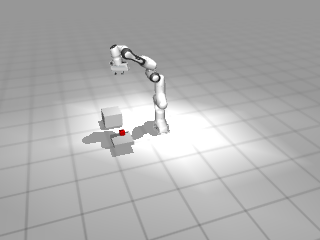

Rendered frame from CustomBerryPickingEnv using camera_id=1 (index)


In [5]:

def default_config() -> config_dict.ConfigDict:
    """Returns the default config for berry picking task."""
    config = config_dict.create(
        ctrl_dt=0.02,
        sim_dt=0.005, # Experiment with 0.005 if needed
        episode_length=150, # Increased episode length
        action_repeat=1,
        action_scale=0.04, # Action scale
        reward_config=config_dict.create(
            scales=config_dict.create(
                gripper_berry=4.0,       # Gripper close to berry (replaces reach and grasp)
                berry_target=8.0,        # Berry close to target position
                gripper_berry_lift=8.0,     # Reward for lifting berry
                robot_collision_penalty=-1.0,
            )
        ),
    )
    return config


class CustomBerryPickingEnv(pick.PandaPickCube):
    def __init__(self, config: config_dict.ConfigDict = default_config()): # Take config as input
        self.config = config # Assign config to self
        # --- XML Path Setup ---
        mjx_panda_path = '/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml'
        modified_xml_string = f"""
<mujoco model="berry_picking_playground_scratch">
    <!-- Include panda robot from mjx_panda.xml using absolute path -->
    <include file="{mjx_panda_path}"/>

    <option timestep="{config.sim_dt}" iterations="100" solver="Newton" gravity="0 0 -9.81"/>

    <!-- Increased friction parameters -->
    <default>
        <geom friction="1.0 0.005 0.0001"/>
    </default>

    <visual>
      <headlight diffuse=".8 .8 .8" ambient=".2 .2 .2" specular="1 1 1"/>
      <global azimuth="-20" elevation="-30"/>
      <rgba force="1 0 0 1"/>
      <map force="0.01"/>
      <quality shadowsize="8192"/>
      <scale contactwidth="0.075" contactheight="0.025" forcewidth="0.05" com="0.05" framewidth="0.01" framelength="0.2"/>
    </visual>

    <size nstack="3000"/>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512"/>
        <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 .2 .3" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>
        <material name="matplane" reflectance="0.3" texture="texplane" texrepeat="1 1" texuniform="true"/>
        <material name="berry" rgba="0.8 0 0 1"/>
        <material name="plate" rgba="0.7 0.7 0.7 1"/>
        <material name="bowl" rgba="0.8 0.8 0.8 1"/>

        <!-- Materials -->
        <material name="white2" rgba="1 1 1 1"/>
        <material name="off_white2" rgba="0.901961 0.921569 0.929412 1"/>
        <material name="black2" rgba="0.25 0.25 0.25 1"/>
        <material name="green2" rgba="0 1 0 1"/>
        <material name="light_blue2" rgba="0.039216 0.541176 0.780392 1"/>

        <!-- Ground plane texture/material -->
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0"/>
    </asset>

    <worldbody>
        <!-- Add Camera here inside worldbody -->
        <camera name="closeup_berry" pos="0.5 0.5 1.5"  mode="targetbodycom" target="berry"/>

        <!-- Ground plane -->
        <geom name="floor" size="0 0 0.05" type="plane" material="groundplane" contype="1"/>

        <!-- Plate -->
        <body name="plate" pos="-0.25 0.5 0.1">
            <geom name="plate_geom" type="box" size="0.1 0.1 0.02" material="plate"/>
        </body>

        <!-- Bowl -->
        <body name="bowl" pos="0.25 0.5 0.1">
            <geom name="bowl_geom" type="box" size="0.1 0.1 0.075" material="bowl"/>
        </body>

        <!-- Berry -->
        <!-- Modified berry with increased size and better graspable shape -->
        <body name="berry" pos="-0.25 0.5 0.135">
            <joint name="berry_joint" type="free" damping="0.1"/>
            <!-- Changed to sphere with larger size and added contact sensors -->

            <geom name="berry_geom" type="box" size="0.025 0.025 0.025" material="berry" mass="0.05"/>
            <site name="berry_top" pos="0 0 0.025" size="0.001"/>
            <site name="berry_bottom" pos="0 0 -0.025" size="0.001"/>
        </body>


         <!-- Panda Robot (included from mjx_panda.xml) -->
    </worldbody>
</mujoco>
        """
        xml_path_custom = "custom_panda_berry.xml"
        with open(xml_path_custom, "w") as f:
            f.write(modified_xml_string)
        xml_path = os.path.abspath(xml_path_custom)
        self._xml_path = xml_path  # Set self._xml_path

        super().__init__(config) # Now call super() with the config


        self._debug_config() # Call the debug method immediately after super().__init__


        # --- Load mj_model and mjx_model AFTER super().__init__ ---
        self._mj_model = mujoco.MjModel.from_xml_path(xml_path)
        self._mjx_model = mjx.put_model(self.mj_model)

        # --- Get actuator IDs for gripper control ---
        self.gripper_actuator_ids = jp.array([
            self.mj_model.actuator('actuator8').id,
        ])

        self._robot_arm_qposadr = self.mj_model.joint("joint1").qposadr[0] # Assuming joint1 is the start of arm joints, adjust if needed. Panda arm has 7 joints.
        self._robot_arm_qpos_num = 7 # Number of joints in Panda arm

        # --- Store initial qpos and qvel ---
        self._init_qpos = jp.array(self.mj_model.qpos0)
        self._init_qvel = jp.zeros(self.mj_model.nv)  # Create qvel as zeros

        # --- Define your specific initial arm joint configuration ---
        desired_arm_qpos = jp.array([
            1.57,      # Joint 1 initial angle
            0.0,   # Joint 2 initial angle (example value) - roughly -45 degrees
            0.0,      # Joint 3 initial angle
            -1.0,   # Joint 4 initial angle - roughly -135 degrees
            0.0,      # Joint 5 initial angle
            0.785,     # Joint 6 initial angle - roughly 90 degrees
            0.0    # Joint 7 initial angle - roughly 45 degrees
        ])

        # --- Replace the arm joint part of _init_qpos with your desired values** ---
        self._init_qpos = self._init_qpos.at[self._robot_arm_qposadr:self._robot_arm_qposadr + self._robot_arm_qpos_num].set(desired_arm_qpos)


        # --- Set initial gripper position to open (using finger_joint1 index)** ---
        finger_joint1_qpos_index = self.mj_model.joint('finger_joint1').qposadr[0]
        open_gripper_qpos_value = 0.08  # Based on ctrlrange="0 0.04" in XML
        self._init_qpos = self._init_qpos.at[finger_joint1_qpos_index].set(open_gripper_qpos_value)


        # --- Update mj_model.qpos0 after modifying _init_qpos ---
        self.mj_model.qpos0 = np.array(self._init_qpos) # Update the underlying mj_model

        # --- Load mj_model and mjx_model AFTER modifying qpos0 ---
        self._mj_model = mujoco.MjModel.from_xml_path(xml_path) # Reload to apply qpos0 changes
        self._mjx_model = mjx.put_model(self.mj_model)

        # --- Get body and geom IDs ---
        self.berry_body_id = self.mj_model.body("berry").id
        self.bowl_body_id = self.mj_model.body("bowl").id


        self.gripper_site_id = self.mj_model.site("gripper").id

        self.left_finger_pad_geom_id = self.mj_model.geom("left_finger_pad").id
        self.right_finger_pad_geom_id = self.mj_model.geom("right_finger_pad").id
        self.berry_geom_id = self.mj_model.geom("berry_geom").id
        self.bowl_geom_id = self.mj_model.geom("bowl_geom").id
        self.plate_geom_id = self.mj_model.geom("plate_geom").id


        self.panda_hand_geom_id = self.mj_model.geom("hand_capsule").id # Panda hand geom ID

        # --- Store initial berry position ---
        self._init_berry_pos = self._init_qpos[self.mj_model.joint("berry_joint").qposadr[0]:self.mj_model.joint("berry_joint").qposadr[0]+3]

    def _debug_config(self):
        print("self.config inside _debug_config:", hasattr(self, 'config')) # Check if self.config exists

    # --- Implement abstract methods as properties (NO lazy loading) ---
    @property
    def action_size(self):
        return 8

    @property
    def mj_model(self):
        return self._mj_model  # Return directly, no lazy loading

    @property
    def mjx_model(self):
        return self._mjx_model  # Return directly, no lazy loading

    @property
    def xml_path(self):
        return self._xml_path

    # --- reset method ---
    def reset(self, rng: jax.Array) -> mjx_env.State:
        rng, rng_berry, rng_target = jax.random.split(rng, 3) # Split rng for berry and target

        # Find the joint address for the 'berry' body's free joint
        berry_joint_id = self.mj_model.joint("berry_joint").id
        berry_qpos_adr = self.mj_model.jnt_qposadr[berry_joint_id]

        # Initialize berry position (example: random position around starting point)
        berry_pos = jax.random.uniform(
            rng,
            (3,),
            minval=jp.array([-0.1, -0.1, 0.0]),  # Small random offset
            maxval=jp.array([0.1, 0.1, 0.0]),
        ) + self._init_berry_pos  # Add the initial position


        # Create a copy of the initial qpos and modify the berry's position
        init_qpos = self._init_qpos.at[berry_qpos_adr:berry_qpos_adr + 3].set(berry_pos)

        # Initialize target position (randomly, similar to PandaPickCube)
        target_pos = (
            jax.random.uniform(
                rng_target,
                (3,),
                minval=jp.array([-0.2, 0.3, 0.1]),  # Example range, adjust as needed
                maxval=jp.array([0.2, 0.7, 0.3]),  # Example range, adjust as needed
            )
        )
        target_pos = jp.clip(target_pos, a_min=jp.array([-1.0, -1.0, 0.0]), a_max=jp.array([1.0, 1.0, 1.0])) # Clip target_pos to reasonable bounds


        data = mjx_env.init(self.mjx_model, init_qpos, self._init_qvel)
        # data = data.replace(
        #     mocap_pos=data.mocap_pos.at[0, :].set(target_pos), # Assuming mocap index 0
        #     mocap_quat=data.mocap_quat.at[0, :].set(jp.array([1.0, 0.0, 0.0, 0.0])), # Identity quaternion
        # )

        obs = self._get_obs(data, {"target_pos": target_pos}) # Pass target_pos directly to _get_obs
        reward = 0.0
        done = 0.0
        metrics = {k: 0.0 for k in self.config.reward_config.scales.keys()}
        # metrics["berry_in_bowl"] = 0.0 # Removed
        info = {"target_pos": target_pos} # Store target_pos in info
        return mjx_env.State(data, obs, reward, done, metrics, info)

    def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:
        # Apply actions with scaling
        delta = action * self.config.action_scale
        ctrl = state.data.ctrl + delta
        # Assuming your Panda robot has joint limits, you might want to clip actions or ctrl here
        # ctrl = jp.clip(ctrl, self._lowers, self._uppers) # Example if you have _lowers and _uppers defined

        data = mjx_env.step(self.mjx_model, state.data, ctrl)

        # Get observation
        obs = self._get_obs(data, state.info)

        # Calculate rewards
        rewards = self._get_reward(data, state.info)
        scaled_rewards = {
            k: v * self.config.reward_config.scales[k]
            for k, v in rewards.items()
        }
        reward = sum(scaled_rewards.values())

        # Check termination conditions (removed berry_in_bowl)
        done = (
            jp.isnan(data.qpos).any()
            | jp.isnan(data.qvel).any()
        )
        done = done.astype(jp.float32)

        # Update metrics
        # Create a new metrics dictionary to avoid modifying the original
        metrics = state.metrics.copy()
        metrics.update(scaled_rewards)
        # metrics["berry_in_bowl"] = berry_in_bowl.astype(float) # Removed berry_in_bowl metric

        # Create a new info dictionary, preserving existing keys and adding new ones
        info = state.info.copy()  # Preserve the original info structure

        # Return a new State object with updated data
        return mjx_env.State(data, obs, reward, done, metrics, info)

    def _get_obs(self, data, info: dict): # Add info as argument
        gripper_pos = data.site_xpos[self.gripper_site_id]
        gripper_mat = data.site_xmat[self.gripper_site_id].ravel()
        berry_pos = data.xpos[self.berry_body_id]
        # bowl_pos = data.xpos[self.bowl_body_id] # Removed

        target_pos = info["target_pos"] # Get target_pos from info

        obs = jp.concatenate([
            data.qpos,
            data.qvel,
            gripper_pos,
            gripper_mat[3:],
            berry_pos,
            berry_pos - gripper_pos,
            # bowl_pos - berry_pos, # Removed
            target_pos - berry_pos, # Use target_pos from info
            data.ctrl,
        ])

        return obs


    def _get_reward(self, data: mjx.Data, info: dict) -> dict:
        """Calculates the simplified reward for pick and place to target."""

        gripper_pos = data.site_xpos[self.gripper_site_id]
        berry_pos = data.xpos[self.berry_body_id]
        # bowl_pos = data.xpos[self.bowl_body_id] # Not used anymore
        target_pos = info["target_pos"] # Get target_pos from info

        # 1. Gripper-Berry Reward (Combined Reach and Grasp)
        dist_gripper_berry = jp.linalg.norm(gripper_pos - berry_pos)
        gripper_berry_reward = 1 - jp.tanh(5 * dist_gripper_berry)  # Similar to gripper_box

        # 2. Berry-Target Reward (Move berry to target)
        dist_berry_target = jp.linalg.norm(berry_pos - target_pos)
        berry_target_reward = 1 - jp.tanh(5 * dist_berry_target) # Similar to box_target

        # 3. Gripper Lift Berry Reward (after "grasp")
        initial_berry_height = self._init_berry_pos[2]
        current_berry_height = berry_pos[2]
        berry_lift_height = current_berry_height - initial_berry_height
        gripper_berry_contact = self.check_gripper_berry_contact(data) # Check contact for lift reward condition
        gripper_berry_lift_reward = jp.where(
            gripper_berry_contact,  # Condition: Grasp (contact)
            jp.clip(berry_lift_height * 10.0, 0.0, 1.0),
            0.0
        )

        # 4. Collision Penalty
        robot_collision = self.check_robot_plate_bowl_collision(data)
        robot_collision_penalty = jp.where(robot_collision, 1.0, 0.0)

        rewards = {
            "gripper_berry": gripper_berry_reward,  # Combined reach and grasp
            "berry_target": berry_target_reward,    # Move to target
            "gripper_berry_lift": gripper_berry_lift_reward, # Lift reward
            "robot_collision_penalty": robot_collision_penalty,
        }

        return rewards


    def check_gripper_berry_contact(self, data: mjx.Data) -> jax.Array:
        """Checks if either finger pad is in contact with the berry using collision.geoms_colliding."""
        # Check for collision between left finger pad and berry
        left_finger_contact = collision.geoms_colliding(
            data, self.left_finger_pad_geom_id, self.berry_geom_id
        )
        # Check for collision between right finger pad and berry
        right_finger_contact = collision.geoms_colliding(
            data, self.right_finger_pad_geom_id, self.berry_geom_id
        )
        # Return True if either finger is in contact (using logical OR)
        return left_finger_contact & right_finger_contact # Logical OR


    def check_robot_plate_bowl_collision(self, data: mjx.Data) -> jax.Array:
        """Checks if robot gripper is colliding with the plate or bowl."""
        # Check for collision between left finger pad and plate/bowl
        left_finger_plate_collision = collision.geoms_colliding(data, self.left_finger_pad_geom_id, self.plate_geom_id)
        left_finger_bowl_collision = collision.geoms_colliding(data, self.left_finger_pad_geom_id, self.bowl_geom_id)

        # Check for collision between right finger pad and plate/bowl
        right_finger_plate_collision = collision.geoms_colliding(data, self.right_finger_pad_geom_id, self.plate_geom_id)
        right_finger_bowl_collision = collision.geoms_colliding(data, self.right_finger_pad_geom_id, self.bowl_geom_id)

        # Check for collision between panda hand and plate/bowl
        panda_hand_plate_collision = collision.geoms_colliding(data, self.panda_hand_geom_id, self.plate_geom_id)
        panda_hand_bowl_collision = collision.geoms_colliding(data, self.panda_hand_geom_id, self.bowl_geom_id)


        # Return True if ANY collision occurs
        is_colliding = (
            left_finger_plate_collision | left_finger_bowl_collision |
            right_finger_plate_collision | right_finger_bowl_collision |
            panda_hand_plate_collision | panda_hand_bowl_collision
        )
        return is_colliding


    # def check_berry_in_bowl(self, data):
    #     """Check for the berry inside the bowl using a simple box check"""
    #     berry_pos = data.geom_xpos[self.berry_geom_id]
    #     bowl_pos = data.geom_xpos[self.bowl_geom_id]
    #     bowl_size = self.mj_model.geom_size[self.bowl_geom_id]

    #     # Simple AABB check (Axis-Aligned Bounding Box)
    #     within_x = (berry_pos[0] >= bowl_pos[0] - bowl_size[0]) & (berry_pos[0] <= bowl_pos[0] + bowl_size[0])
    #     within_y = (berry_pos[1] >= bowl_pos[1] - bowl_size[1]) & (berry_pos[1] <= bowl_pos[1] + bowl_size[1])
    #     within_z = (berry_pos[2] >= bowl_pos[2]) & (berry_pos[2] <= bowl_pos[2] + 0.4)
    #     in_bowl = within_x & within_y & within_z
    #     return in_bowl

# 3. Instantiate and Test
env = CustomBerryPickingEnv()
reset_state = env.reset(jax.random.PRNGKey(0))


# Take a few steps and check rewards
for _ in range(1):
    action = jp.zeros(env.action_size)  # Zero action for now
    state = env.step(reset_state, action)
    print(f"Step Reward: {state.reward}, Metrics: {state.metrics}, Done: {state.done}")
    reset_state = state # Update state

# Render and display (after some steps)
# Render and display (after some steps)
frame = env.render([state])[0] # Try camera_id=1 (index)
media.show_image(frame)
print("Rendered frame from CustomBerryPickingEnv using camera_id=1 (index)")


In [ ]:
"""Bring a box to a target and orientation."""

from typing import Any, Dict, Optional, Union

import jax
import jax.numpy as jp
from ml_collections import config_dict
from mujoco import mjx
from mujoco.mjx._src import math
import numpy as np
from etils import epath

from mujoco_playground._src import collision
from mujoco_playground._src import mjx_env
from mujoco_playground._src.manipulation.franka_emika_panda import panda
from mujoco_playground._src.mjx_env import State  # pylint: disable=g-importing-member


def default_config() -> config_dict.ConfigDict:
  """Returns the default config for bring_to_target tasks."""
  config = config_dict.create(
      ctrl_dt=0.02,
      sim_dt=0.005,
      episode_length=150,
      action_repeat=1,
      action_scale=0.04,
      reward_config=config_dict.create(
          scales=config_dict.create(
              # Gripper goes to the box.
              gripper_box=4.0,
              # Box goes to the target mocap.
              box_target=8.0,
              # Do not collide the gripper with the floor.
              no_floor_collision=0.25,
              # Arm stays close to target pose.
              robot_target_qpos=0.3,
          )
      ),
  )
  return config


class PandaPickCube(panda.PandaBase):
  """Bring a box to a target."""

  def __init__(
      self,
      config: config_dict.ConfigDict = default_config(),
      config_overrides: Optional[Dict[str, Union[str, int, list[Any]]]] = None,
      sample_orientation: bool = False,
  ):
    xml_panda_path = '/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml'
    custom_xml =
    f"""
<mujoco model="panda_combined">
  <include file={xml_panda_path}/>

  <statistic center="0.3 0 0.4" extent="1"/>

  <option timestep="0.005" iterations="5" ls_iterations="8" integrator="implicitfast">
    <flag eulerdamp="disable"/>
  </option>

  <custom>
    <numeric data="12" name="max_contact_points"/>
  </custom>

  <visual>
    <headlight diffuse=".8 .8 .8" ambient=".2 .2 .2" specular="1 1 1"/>
    <rgba force="1 0 0 1"/>
    <global azimuth="-40" elevation="-30"/>
    <map force="0.01"/>
    <quality shadowsize="8192"/>
    <scale contactwidth="0.075" contactheight="0.025" forcewidth="0.05" com="0.05" framewidth="0.01" framelength="0.2"/>
  </visual>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1="1 1 1" rgb2="1 1 1" width="800" height="800"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0"
      width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0"/>
  </asset>

  <worldbody>
    <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
    <geom name="floor" size="0 0 0.05" type="plane" material="groundplane" contype="1"/>

    <body name="box" pos="0.5 0 0.03">
      <freejoint/>
      <geom type="box" name="box" size="0.02 0.02 0.03" condim="3"
       friction="1 .03 .003" rgba="0 1 0 1" contype="2" conaffinity="1" solref="0.01 1"/>
    </body>

    <body mocap="true" name="mocap_target">
      <geom type="box" size="0.02 0.02 0.03" rgba="1 0 0 0.2" contype="0" conaffinity="0"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="home"
      qpos="0 0.3 0 -1.57079 0 2.0 -0.7853 0.04 0.04 0.7 0 0.03 1 0 0 0"
      ctrl="0 0.3 0 -1.57079 0 2.0 -0.7853 0.04"/>
    <key name="pickup"
      qpos="0.2897 0.50732 -0.140016 -2.176 -0.0310497 2.51592 -0.49251 0.04 0.0399982 0.511684 0.0645413 0.0298665 0.665781 2.76848e-17 -2.27527e-17 -0.746147"
      ctrl="0.2897 0.423 -0.144392 -2.13105 -0.0291743 2.52586 -0.492492 0.04"/>
    <key name="pickup1"
      qpos='0.2897 0.496673 -0.142836 -2.14746 -0.0295746 2.52378 -0.492496 0.04 0.0399988 0.529553 0.0731702 0.0299388 0.94209 8.84613e-06 -4.97524e-06 -0.335361'
      ctrl="0.2897 0.458 -0.144392 -2.13105 -0.0291743 2.52586 -0.492492 0.04"/>
  </keyframe>
</mujoco>
    """
    xml_path_custom = "custom_panda_berry.xml"
    with open(xml_path_custom, "w") as f:
        f.write(modified_xml_string)
    # xml_path = os.path.abspath(xml_path_custom)

    xml_path = epath.Path(xml_path_custom)

    super().__init__(
        xml_path,
        config,
        config_overrides,
    )
    self._post_init(obj_name="box", keyframe="home")
    self._sample_orientation = sample_orientation

  def reset(self, rng: jax.Array) -> State:
    rng, rng_box, rng_target = jax.random.split(rng, 3)

    # intialize box position
    box_pos = (
        jax.random.uniform(
            rng_box,
            (3,),
            minval=jp.array([-0.2, -0.2, 0.0]),
            maxval=jp.array([0.2, 0.2, 0.0]),
        )
        + self._init_obj_pos
    )

    # initialize target position
    target_pos = (
        jax.random.uniform(
            rng_target,
            (3,),
            minval=jp.array([-0.2, -0.2, 0.2]),
            maxval=jp.array([0.2, 0.2, 0.4]),
        )
        + self._init_obj_pos
    )

    target_quat = jp.array([1.0, 0.0, 0.0, 0.0], dtype=float)
    if self._sample_orientation:
      # sample a random direction
      rng, rng_axis, rng_theta = jax.random.split(rng, 3)
      perturb_axis = jax.random.uniform(rng_axis, (3,), minval=-1, maxval=1)
      perturb_axis = perturb_axis / math.norm(perturb_axis)
      perturb_theta = jax.random.uniform(rng_theta, maxval=np.deg2rad(45))
      target_quat = math.axis_angle_to_quat(perturb_axis, perturb_theta)

    # initialize data
    init_q = (
        jp.array(self._init_q)
        .at[self._obj_qposadr : self._obj_qposadr + 3]
        .set(box_pos)
    )
    data = mjx_env.init(
        self._mjx_model,
        init_q,
        jp.zeros(self._mjx_model.nv, dtype=float),
        ctrl=self._init_ctrl,
    )

    # set target mocap position
    data = data.replace(
        mocap_pos=data.mocap_pos.at[self._mocap_target, :].set(target_pos),
        mocap_quat=data.mocap_quat.at[self._mocap_target, :].set(target_quat),
    )

    # initialize env state and info
    metrics = {
        "out_of_bounds": jp.array(0.0, dtype=float),
        **{k: 0.0 for k in self._config.reward_config.scales.keys()},
    }
    info = {"rng": rng, "target_pos": target_pos, "reached_box": 0.0}
    obs = self._get_obs(data, info)
    reward, done = jp.zeros(2)
    state = State(data, obs, reward, done, metrics, info)
    return state

  def step(self, state: State, action: jax.Array) -> State:
    delta = action * self._action_scale
    ctrl = state.data.ctrl + delta
    ctrl = jp.clip(ctrl, self._lowers, self._uppers)

    data = mjx_env.step(self._mjx_model, state.data, ctrl, self.n_substeps)

    raw_rewards = self._get_reward(data, state.info)
    rewards = {
        k: v * self._config.reward_config.scales[k]
        for k, v in raw_rewards.items()
    }
    reward = jp.clip(sum(rewards.values()), -1e4, 1e4)
    box_pos = data.xpos[self._obj_body]
    out_of_bounds = jp.any(jp.abs(box_pos) > 1.0)
    out_of_bounds |= box_pos[2] < 0.0
    done = out_of_bounds | jp.isnan(data.qpos).any() | jp.isnan(data.qvel).any()
    done = done.astype(float)

    state.metrics.update(
        **raw_rewards, out_of_bounds=out_of_bounds.astype(float)
    )

    obs = self._get_obs(data, state.info)
    state = State(data, obs, reward, done, state.metrics, state.info)

    return state

  def _get_reward(self, data: mjx.Data, info: Dict[str, Any]) -> Dict[str, Any]:
    target_pos = info["target_pos"]
    box_pos = data.xpos[self._obj_body]
    gripper_pos = data.site_xpos[self._gripper_site]
    pos_err = jp.linalg.norm(target_pos - box_pos)
    box_mat = data.xmat[self._obj_body]
    target_mat = math.quat_to_mat(data.mocap_quat[self._mocap_target])
    rot_err = jp.linalg.norm(target_mat.ravel()[:6] - box_mat.ravel()[:6])

    box_target = 1 - jp.tanh(5 * (0.9 * pos_err + 0.1 * rot_err))
    gripper_box = 1 - jp.tanh(5 * jp.linalg.norm(box_pos - gripper_pos))
    robot_target_qpos = 1 - jp.tanh(
        jp.linalg.norm(
            data.qpos[self._robot_arm_qposadr]
            - self._init_q[self._robot_arm_qposadr]
        )
    )

    # Check for collisions with the floor
    hand_floor_collision = [
        collision.geoms_colliding(data, self._floor_geom, g)
        for g in [
            self._left_finger_geom,
            self._right_finger_geom,
            self._hand_geom,
        ]
    ]
    floor_collision = sum(hand_floor_collision) > 0
    no_floor_collision = (1 - floor_collision).astype(float)

    info["reached_box"] = 1.0 * jp.maximum(
        info["reached_box"],
        (jp.linalg.norm(box_pos - gripper_pos) < 0.012),
    )

    rewards = {
        "gripper_box": gripper_box,
        "box_target": box_target * info["reached_box"],
        "no_floor_collision": no_floor_collision,
        "robot_target_qpos": robot_target_qpos,
    }
    return rewards

  def _get_obs(self, data: mjx.Data, info: dict[str, Any]) -> jax.Array:
    gripper_pos = data.site_xpos[self._gripper_site]
    gripper_mat = data.site_xmat[self._gripper_site].ravel()
    target_mat = math.quat_to_mat(data.mocap_quat[self._mocap_target])
    obs = jp.concatenate([
        data.qpos,
        data.qvel,
        gripper_pos,
        gripper_mat[3:],
        data.xmat[self._obj_body].ravel()[3:],
        data.xpos[self._obj_body] - data.site_xpos[self._gripper_site],
        info["target_pos"] - data.xpos[self._obj_body],
        target_mat.ravel()[:6] - data.xmat[self._obj_body].ravel()[:6],
        data.ctrl - data.qpos[self._robot_qposadr[:-1]],
    ])

    return obs


class PandaPickCubeOrientation(PandaPickCube):
  """Bring a box to a target and orientation."""

  def __init__(
      self,
      config: config_dict.ConfigDict = default_config(),
      config_overrides: Optional[Dict[str, Union[str, int, list[Any]]]] = None,
  ):
    super().__init__(config, config_overrides, sample_orientation=True)



# Instantiate and Test
env = PandaPickCube()
reset_state = env.reset(jax.random.PRNGKey(0))


# Take a few steps and check rewards
for _ in range(1):
    action = jp.zeros(env.action_size)  # Zero action for now
    state = env.step(reset_state, action)
    print(f"Step Reward: {state.reward}, Metrics: {state.metrics}, Done: {state.done}")
    reset_state = state # Update state

# Render and display (after some steps)
# Render and display (after some steps)
frame = env.render([state])[0] # Try camera_id=1 (index)
media.show_image(frame)
print("Rendered frame from CustomBerryPickingEnv using camera_id=1 (index)")

ValueError: XML Error: File '/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml' already included
Element 'include', line 0


## Training

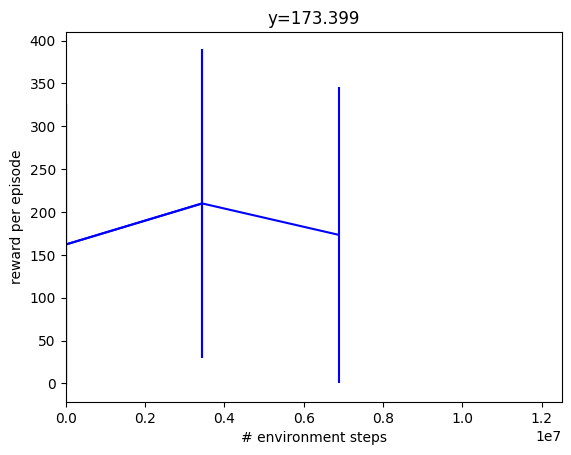

KeyboardInterrupt: 

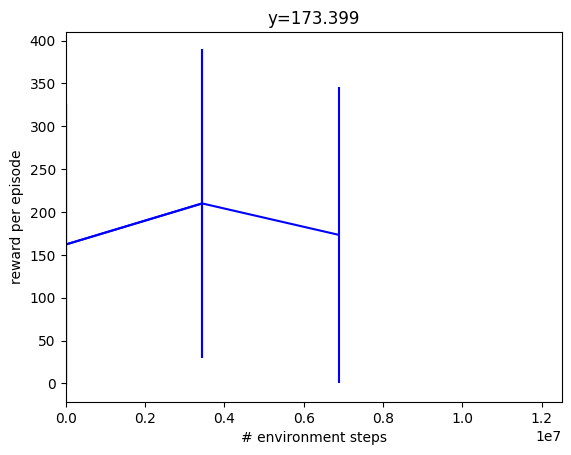

In [ ]:
ppo_params = {
    'action_repeat': 1,
    'batch_size': 512,
    'discounting': 0.97,
    'entropy_cost': 0.02,
    'episode_length': 150,
    'learning_rate': 0.002,
    'network_factory': {
        'policy_hidden_layer_sizes': (32, 32, 32, 32),
        'policy_obs_key': 'state',
        'value_hidden_layer_sizes': (256, 256, 256, 256, 256),
        'value_obs_key': 'state'
    },
    'normalize_observations': True,
    'num_envs': 2048,
    'num_evals': 4,
    'num_minibatches': 32,
    'num_timesteps': 10000000,
    'num_updates_per_batch': 8,
    'reward_scaling': 1.0,
    'unroll_length': 10
}


x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_training_params:

  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_training_params["network_factory"]
  )

  del ppo_training_params["network_factory"]

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress,
    seed=1
)


make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1
episode_length = 150

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
# frames = env.render(rollout[::render_every], camera="closeup_berry")
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/xla.py:155: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/xla.py:155: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/xla.py:155: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
100%|██████████| 151/151 [00:00<00:00, 338.54it/s]


In [ ]:
# --- Add print statements for reward metrics during rendering ---
print("Reward Metrics during final rendering (every 100 frames):")
for i, state in enumerate(rollout[::render_every]):
    if i % 100 == 0:  # Print metrics every 10 frames (adjust as needed)
        print(f"  Frame {i*render_every}, Total Reward: {state.reward:.3f}")
        for metric_name, metric_value in state.metrics.items():
            print(f"    {metric_name}: {metric_value:.3f}")
        if "berry_in_bowl_bonus" in state.metrics:
            print(f"    Berry in Bowl Bonus: {state.metrics['berry_in_bowl_bonus']:.3f}") # Example specific metric

Reward Metrics during final rendering (every 100 frames):
  Frame 0, Total Reward: 0.000
    berry_bowl_move: 0.000
    berry_in_bowl: 0.000
    berry_in_bowl_bonus: 0.000
    gripper_berry_grasp: 0.000
    gripper_berry_lift: 0.000
    gripper_berry_reach: 0.000
    robot_collision_penalty: 0.000
    Berry in Bowl Bonus: 0.000
  Frame 100, Total Reward: 2.680
    berry_bowl_move: 0.000
    berry_in_bowl: 0.000
    berry_in_bowl_bonus: 0.000
    gripper_berry_grasp: 0.000
    gripper_berry_lift: 0.000
    gripper_berry_reach: 2.680
    robot_collision_penalty: 0.000
    Berry in Bowl Bonus: 0.000
  Frame 200, Total Reward: 0.164
    berry_bowl_move: 0.000
    berry_in_bowl: 0.000
    berry_in_bowl_bonus: 0.000
    gripper_berry_grasp: 0.000
    gripper_berry_lift: 0.000
    gripper_berry_reach: 0.164
    robot_collision_penalty: 0.000
    Berry in Bowl Bonus: 0.000
  Frame 300, Total Reward: 1.943
    berry_bowl_move: 0.000
    berry_in_bowl: 0.000
    berry_in_bowl_bonus: 0.000
    gr

## Testing direct control on panda

In [7]:
import time
import numpy as np
import mediapy as media
import mujoco
import mujoco.viewer

# # Re-use the environment setup from your training code to load the model and data
# env = CustomBerryPickingEnv()
# mj_model = env.mj_model
# mj_data = mujoco.MjData(mj_model)

# Initialize renderer
renderer = mujoco.Renderer(mj_model, width=480, height=480)

# --- Define a sequence of joint positions to command ---
# Example: Move joints 1, 2, 3 in a sinusoidal pattern, keep others relatively fixed
num_steps = 200
joint_trajectory = []

for i in range(num_steps):
    angle = 2 * np.pi * i / num_steps  # Angle for sinusoidal motion
    target_positions = np.array([
        0.5 * np.sin(angle),  # Joint 1: Sinusoidal motion
        0.5 * np.cos(angle),  # Joint 2: Cosinusoidal motion (shifted phase)
        0.3 * np.sin(2 * angle), # Joint 3: Sinusoidal with double frequency
        -1.5,                  # Joint 4: Fixed (approximately straight elbow down)
        0.0,                   # Joint 5: Fixed
        2.0,                   # Joint 6: Fixed (wrist up)
        -0.785,                # Joint 7: Fixed (wrist angle)
        0.04 if i % 40 < 20 else 0.0 # Gripper: Open for 20 steps, then closed for 20 steps
    ])
    joint_trajectory.append(target_positions)

# --- Simulation and Rendering Loop ---
frames = []
mujoco.mj_resetData(mj_model, mj_data) # Reset data at the beginning
for target_ctrl in joint_trajectory:
    # Set the control array directly
    mj_data.ctrl[:] = target_ctrl

    # Step the simulation forward
    mujoco.mj_step(mj_model, mj_data) # Use mj_step for core MuJoCo simulation

    # Render the scene
    renderer.update_scene(mj_data)
    pixels = renderer.render()
    frames.append(pixels)

# --- Create and display the video ---
fps = 30  # Frames per second for the video
media.show_video(frames, fps=fps)


self.config inside _debug_config: True


In [27]:
import time
import numpy as np
import mediapy as media
import mujoco

# --- Define a new 3-DOF Arm XML with box links, proper joints, and better orientation ---
box_arm_xml_string = """
<mujoco model="box_3dof_arm">
  <option timestep="0.005" iterations="10" solver="Newton"/>

  <visual>
    <global azimuth="120" elevation="-20"/>
  </visual>

  <asset>
    <material name="grid" reflectance="0.5" rgba="0.9 0.9 0.9 1" specular="0.1"/>
    <material name="base_material" rgba="0.3 0.3 0.3 1"/>
    <material name="link1_material" rgba="0.7 0.0 0.0 1"/>
    <material name="link2_material" rgba="0.0 0.7 0.0 1"/>
    <material name="link3_material" rgba="0.0 0.0 0.7 1"/>
    <material name="end_effector" rgba="1.0 0.7 0.0 1"/>
  </asset>

  <worldbody>
    <!-- Ground plane -->
    <light name="light" pos="0 0 2" dir="0 0 -1" diffuse="0.8 0.8 0.8"/>
    <geom name="ground" type="plane" size="2 2 0.1" material="grid"/>

    <!-- Fixed base -->
    <body name="base" pos="0 0 0.1">
      <geom name="base_geom" type="box" size="0.1 0.1 0.05" material="base_material"/>

      <!-- First link - rotates around the Z axis -->
      <body name="link1" pos="0 0 0.05">
        <joint name="joint1" type="hinge" axis="0 1 0" pos="0 0 0" range="-3.14 3.14" damping="20"/>
        <geom name="link1_geom" type="box" size="0.15 0.05 0.04" pos="0.15 0 0" material="link1_material"/>

        <!-- Second link - rotates around the Y axis -->
        <body name="link2" pos="0.3 0 0">
          <joint name="joint2" type="hinge" axis="0 1 0" pos="0 0 0" range="-3.14 3.14" damping="20"/>
          <geom name="link2_geom" type="box" size="0.15 0.04 0.03" pos="0.15 0 0" material="link2_material"/>

          <!-- Third link - rotates around the X axis -->
          <body name="link3" pos="0.3 0 0">
            <joint name="joint3" type="hinge" axis="1 0 0" pos="0 0 0" range="-3.14 3.14" damping="20"/>
            <geom name="link3_geom" type="box" size="0.1 0.03 0.03" pos="0.1 0 0" material="link3_material"/>

            <!-- End effector -->
            <body name="end_effector" pos="0.2 0 0">
              <geom name="ee_geom" type="sphere" size="0.02" material="end_effector"/>
              <site name="ee_site" pos="0 0 0" size="0.01"/>
            </body>
          </body>
        </body>
      </body>
    </body>
  </worldbody>

  <actuator>
    <position name="actuator1" joint="joint1" kp="1000" kv="20" ctrlrange="-3.14 3.14"/>  <!-- Increased kp and kv -->
    <position name="actuator2" joint="joint2" kp="1000" kv="20" ctrlrange="-3.14 3.14"/>  <!-- Increased kp and kv -->
    <position name="actuator3" joint="joint3" kp="1000" kv="20" ctrlrange="-3.14 3.14"/>  <!-- Increased kp and kv -->
  </actuator>
</mujoco>
"""

# --- Load the model and create data ---
mj_model = mujoco.MjModel.from_xml_string(box_arm_xml_string)
mj_data = mujoco.MjData(mj_model)

# --- Initialize renderer ---
renderer = mujoco.Renderer(mj_model, width=640, height=480)

# --- Simulation and Rendering Loop ---
frames = []
mujoco.mj_resetData(mj_model, mj_data)

# Set the desired duration and frame rate
duration = 10.0  # seconds
fps = 30

# Calculate total simulation steps and frame capture interval
timestep = mj_model.opt.timestep
total_steps = int(duration / timestep)
frame_steps = int(1.0 / (fps * timestep))  # How many simulation steps between frames

# Define a simple trajectory of joint angles
joint_angles_trajectory = []

for i in range(total_steps):
    time_val = i * timestep

    # Example trajectory: sinusoidal motion for each joint
    angle1 = 0.5 * np.sin(2 * np.pi * 0.2 * time_val)  # Joint 1: Sine wave, slow oscillation
    angle2 = 0.5 * np.cos(2 * np.pi * 0.3 * time_val)  # Joint 2: Cosine wave, slightly faster
    angle3 = 0.3 * np.sin(2 * np.pi * 0.5 * time_val)  # Joint 3: Sine wave, faster and smaller amplitude

    joint_angles_trajectory.append([angle1, angle2, angle3])

# Run simulation with the calculated trajectory
for i, target_angles in enumerate(joint_angles_trajectory):
    # Set joint control signals
    mj_data.ctrl[:] = target_angles

    # Step the simulation
    mujoco.mj_step(mj_model, mj_data)

    # Only capture frames at the specified interval (to achieve desired fps)
    if i % frame_steps == 0:
        renderer.update_scene(mj_data)
        pixels = renderer.render()
        frames.append(pixels)

    # Stop if we've exceeded our duration
    if i * timestep >= duration:
        break

# Create and display the video
media.show_video(frames, fps=fps)
print(f"3-DOF box arm simulation complete - {len(frames)} frames at {fps} fps for {duration}s duration")

3-DOF box arm simulation complete - 334 frames at 30 fps for 10.0s duration
